In [48]:
# Importing the libraries
import numpy as np 
import tensorflow as tf 
import pandas as pd
from functools import reduce
import operator
import re 
import collections
import random
import math

In [49]:
# importing the dataset
dataset = pd.read_csv('md.tsv', delimiter = '\t', quoting = 3)

In [50]:
dataset

Title  \
0                           Medical Student Father - AMA   
1      Why is MD tuition so much more expensive than PA?   
2      Feeling demotivated by the threats facing phys...   
3                      Why or why not internal medicine?   
4                  Dismiss or Withdrawal from Med School   
5      Is medicine worth doing? when the IT industry ...   
6                  Experiences in other medical schools?   
7                                  Dress for Conferences   
8                                         ERAS Deadlines   
9                            Depression in med school...   
10                             When can I get a 20k car?   
11     Schizoaffectiveness disorder dx should I forge...   
12            What did you diagnose yourself with today?   
13                           Vascular Surgery Fellow AMA   
14                                  Step 1 Study Partner   
15          Anki account randomly corrupted? How to fix?   
16     MD-1, Tore ACL - depressed and struggling whet...   
17                       Long Hair in Clinical Rotations   
18                             Medscape Comp Report 2018   
19                    Best hematology textbook/resource?   
20     what are the merits of staying in academia onc...   
21                                           Suggestions   
22     Help! I got a <128 on NBME 13. I'm stuck! Need...   
23     Multiple Attempts and Matched (2016)- Took 7 S...   
24                     salary of caidiac surgeons in LA.   
25                End of M3 - need to narrow things down   
26                                    Zanki microbiology   
27                      Other Sites for midical students   
28                        Best immunology book/resource?   
29                         Matching back to CA from JHU?   
...                                                  ...   
30332             The AMA and the Campaign Unity Project   
30333                                                NaN   
30334                                            usmle 2   
30335                                                NaN   
30336                                              TUCOM   
30337                                                NaN   
30338           Supplemental Income for resident doctors   
30339                                                NaN   
30340                                          Textbooks   
30341                                                NaN   
30342                      Good price for Netter's book?   
30343                                                NaN   
30344         residency and research oportunities for DO   
30345                                                NaN   
30346  Ohio State University: Has anyone interviewed ...   
30347                                                NaN   
30348                                   ObGyn Electives?   
30349                                                NaN   
30350                        ACCEPTED!!!!!!Thank God!!!!   
30351                                                NaN   
30352                              Brainstorming * Help!   
30353                                                NaN   
30354                            Residency Oppurtunities   
30355                                                NaN   
30356                          thankyou from please help   
30357                                                NaN   
30358                             Does Peace Corps help?   
30359                                                NaN   
30360                      USMLE Part 1 CBT field trials   
30361                                                NaN   

                   Username Replies   Views  
0               medicalpoet       2      62  
1         watermelon master       4     531  
2             Money Moniker      92   3,300  
3                  remedy23      16   1,056  
4                  dansmith      17   1,324  
5                  lmay0001      77   5,140  
6       

In [51]:
# Cleaning the texts and creating a vocabulary list
def gen_corpus():
    corpus = []
    for i in range(0, 30314):
        question = re.sub('[^a-zA-Z]', ' ', str(dataset['Title'][i]))
        question = question.lower()
        question = question.split()
        corpus.append(question)

    corpus = reduce(operator.concat, corpus)
    return corpus

In [52]:
vocabulary = gen_corpus()

In [53]:
vocabulary

['medical',
 'student',
 'father',
 'ama',
 'why',
 'is',
 'md',
 'tuition',
 'so',
 'much',
 'more',
 'expensive',
 'than',
 'pa',
 'feeling',
 'demotivated',
 'by',
 'the',
 'threats',
 'facing',
 'physician',
 'compensation',
 'why',
 'or',
 'why',
 'not',
 'internal',
 'medicine',
 'dismiss',
 'or',
 'withdrawal',
 'from',
 'med',
 'school',
 'is',
 'medicine',
 'worth',
 'doing',
 'when',
 'the',
 'it',
 'industry',
 'is',
 'blooming',
 'experiences',
 'in',
 'other',
 'medical',
 'schools',
 'dress',
 'for',
 'conferences',
 'eras',
 'deadlines',
 'depression',
 'in',
 'med',
 'school',
 'when',
 'can',
 'i',
 'get',
 'a',
 'k',
 'car',
 'schizoaffectiveness',
 'disorder',
 'dx',
 'should',
 'i',
 'forget',
 'about',
 'medicine',
 'and',
 'move',
 'on',
 'what',
 'did',
 'you',
 'diagnose',
 'yourself',
 'with',
 'today',
 'vascular',
 'surgery',
 'fellow',
 'ama',
 'step',
 'study',
 'partner',
 'anki',
 'account',
 'randomly',
 'corrupted',
 'how',
 'to',
 'fix',
 'md',
 'tore'

In [54]:
vocabulary[:25]

['medical',
 'student',
 'father',
 'ama',
 'why',
 'is',
 'md',
 'tuition',
 'so',
 'much',
 'more',
 'expensive',
 'than',
 'pa',
 'feeling',
 'demotivated',
 'by',
 'the',
 'threats',
 'facing',
 'physician',
 'compensation',
 'why',
 'or',
 'why']

In [55]:
len(vocabulary)

169523

In [56]:
# Bulding the dataset in a format that will be usefull when generating the word to vec embeddings
# Embeddings will be generated only for the top(n) most frequently used words

def build_dataset(words, n_words):
    # Lists of lists holding words and the count of how many times it appears in the dataset
    # Words not in the top (n) will be added to the unknown count
    word_counts = [['UNKNOWN', -1]] 
    
    # Access the most frequently used words
    counter = collections.Counter(words)
    
    # Mostly frequently used words
    word_counts.extend(counter.most_common(n_words - 1))
    
    # The words are to be fed into a neural network inorder to generate word embeddings which
    # Which can only accept numeric data
    # Higher frequency words will have lower indexes
    dictionary = dict()
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 # dictionary['UNKNOWN]
            unknown_count += 1
        word_indexes.append(index)
    word_counts[0][1] = unknown_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return word_counts, word_indexes, dictionary, reversed_dictionary

In [89]:
VOCABULARY_SIZE = 10000
word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [90]:
word_counts[:10]

[['UNKNOWN', 2506],
 ('to', 3712),
 ('for', 3494),
 ('school', 3060),
 ('in', 2840),
 ('a', 2742),
 ('of', 2556),
 ('med', 2402),
 ('the', 2251),
 ('and', 2172)]

In [91]:
word_indexes[:10]

[10, 38, 3127, 427, 69, 16, 61, 409, 107, 97]

In [92]:
for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

antithrombotic : 9648
weekend : 2655
cme : 3150
downloads : 6235
behavioral : 1035
structure : 2711
mixed : 3939
yearitis : 5968
rising : 2169
reverse : 7430


In [93]:
for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

2097 : fmg
1579 : placement
7092 : ambien
6699 : gastroenteritis
5374 : unwritten
1556 : spending
4589 : bar
1294 : southwestern
1693 : listing
5331 : annotation


In [94]:
# Generating Training Batches
# Global index into words maintained across batches
global_index = 0

In [95]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # [ skip_window input_word skip_window]
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    for i in range(batch_size // num_skips):
        target = skip_window # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span -1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window] # this is the input word
            labels[i * num_skips + j, 0] = buffer[target] # these are the context words
            
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    return batch, labels   

In [96]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [97]:
batch

array([ 16,  16,  61,  61, 409, 409, 107, 107,  97,  97], dtype=int32)

In [98]:
labels

array([[ 69],
       [ 10],
       [ 16],
       [107],
       [232],
       [ 97],
       [427],
       [ 61],
       [ 69],
       [422]], dtype=int32)

In [99]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

is :  why
is :  medical
md :  is
md :  so
tuition :  than
tuition :  much
so :  ama
so :  md
much :  why


In [100]:
# Reset the global index because we updated while testing the batch code
global_index = 0

In [101]:
# Constructing the neural network
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [102]:
num_samples = 64 # Number of corrupted sample pairs to feed into NCE

In [103]:
batch_size = 200 # Hyperparameter
embedding_size = 50 # Number of dimentions (Hidden Layer = 50 Neurons)
skip_window = 2
num_skips = 2

In [104]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [105]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32) 

In [106]:
embeddings = tf.Variable(tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [107]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32_ref>

In [108]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(200, 50) dtype=float32>

In [109]:
# Linear Hidden Layer
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [110]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                  biases = nce_biases,
                  labels = train_labels,
                  inputs=embed,
                  num_sampled=num_samples,
                  num_classes=VOCABULARY_SIZE))

In [111]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [112]:
# Training the Neural Network
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / l2_norm

In [113]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [114]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1:0' shape=(16, 50) dtype=float32>

In [115]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [116]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [117]:
init = tf.global_variables_initializer()

In [118]:
num_steps = 200000 # Epocs

In [120]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print("Average loss at step ", step, ': ', average_loss)
            average_loss = 0
            
        # NOTE it is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in range(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # Number of the nearest neighbours
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s, ' % (log_str, close_word)
                print(log_str)
            print("\n")
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  219.2620086669922
Nearest to anatomy: nuero,  serious,  gonna,  ingredients,  colour,  protections,  mepp,  differently, 
Nearest to review: dressing,  ms,  alone,  interest,  puns,  incorporate,  procedures,  frustrating, 
Nearest to university: reporting,  fatalis,  arrest,  rheumatology,  coverages,  bamboo,  hacking,  likelihood, 
Nearest to that: goodbye,  global,  computational,  workflowy,  considering,  invitation,  smaller,  suspect, 
Nearest to school: merits,  brag,  sought,  einstein,  quintiles,  apple,  raised,  ohio, 
Nearest to exam: fellowships,  emails,  caserooni,  applications,  kindle,  statment,  tick,  dictation, 
Nearest to if: coverings,  dense,  mba,  tissues,  exempt,  meaning,  memorazation,  usimgs, 
Nearest to match: sanity,  isnt,  evacuation,  policies,  arch,  msg,  draining,  club, 
Nearest to research: diploma,  msfc,  commencement,  theranos,  philadelphia,  studyable,  licensed,  turnover, 
Nearest to UNKNOWN: looking,  co

Average loss at step  46000 :  6.230424666166305
Average loss at step  48000 :  6.207271591186523
Average loss at step  50000 :  6.122218673944473
Nearest to anatomy: selling,  serious,  paid,  positions,  einstein,  nymc,  lors,  professions, 
Nearest to review: ms,  interest,  alone,  nervous,  procedures,  speaking,  senior,  frustrating, 
Nearest to university: type,  breakup,  wanted,  reporting,  choose,  washington,  campus,  pbl, 
Nearest to that: considering,  tricks,  full,  good,  health,  cohort,  figure,  global, 
Nearest to school: brag,  ask,  UNKNOWN,  delete,  einstein,  side,  apple,  presentations, 
Nearest to exam: fellowships,  let,  emails,  old,  average,  applications,  amcas,  navy, 
Nearest to if: mba,  field,  kind,  start,  deferring,  sc,  intern,  difficulty, 
Nearest to match: already,  application,  coast,  crazy,  images,  teach,  done,  transferring, 
Nearest to research: philadelphia,  delete,  hands,  stuff,  histo,  disorder,  competitive,  vs, 
Nea

Average loss at step  92000 :  5.145940936923027
Average loss at step  94000 :  5.123129706382752
Average loss at step  96000 :  5.097284562468529
Average loss at step  98000 :  5.051700297117233
Average loss at step  100000 :  5.038592651605606
Nearest to anatomy: positions,  selling,  serious,  sloan,  professions,  negotiating,  mohs,  paid, 
Nearest to review: ms,  interest,  alone,  dressing,  speaking,  frustrating,  nervous,  ace, 
Nearest to university: breakup,  type,  wanted,  essentials,  washington,  rheumatology,  dvds,  ivy, 
Nearest to that: tricks,  figure,  cohort,  full,  considering,  goodbye,  save,  edp, 
Nearest to school: apple,  groove,  brag,  presentations,  delete,  neoucom,  side,  direct, 
Nearest to exam: let,  emails,  fellowships,  old,  average,  amcas,  applications,  navy, 
Nearest to if: mba,  field,  sc,  retain,  hungry,  deferring,  party,  kind, 
Nearest to match: already,  application,  coast,  east,  teach,  categorical,  sanity,  images, 
Near

Average loss at step  142000 :  4.8931045944690705
Average loss at step  144000 :  4.886396151304245
Average loss at step  146000 :  4.894373755097389
Average loss at step  148000 :  4.8975086545944215
Average loss at step  150000 :  4.891822461128235
Nearest to anatomy: positions,  mohs,  sloan,  selling,  professions,  negotiating,  serious,  neurogenic, 
Nearest to review: ms,  interest,  dressing,  alone,  speaking,  frustrating,  incorporate,  ace, 
Nearest to university: breakup,  type,  wanted,  washington,  essentials,  dvds,  rheumatology,  principles, 
Nearest to that: tricks,  figure,  cohort,  legend,  save,  full,  tick,  goodbye, 
Nearest to school: groove,  apple,  brag,  presentations,  delete,  gunning,  neoucom,  killer, 
Nearest to exam: let,  emails,  fellowships,  old,  average,  nbme,  dpc,  amcas, 
Nearest to if: mba,  field,  retain,  sc,  hungry,  coverings,  party,  deferring, 
Nearest to match: already,  application,  east,  teach,  coast,  standardized,  san

Average loss at step  192000 :  4.82666191983223
Average loss at step  194000 :  4.824544223070145
Average loss at step  196000 :  4.817918686747551
Average loss at step  198000 :  4.811767263770103


In [122]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
save_words_embeddings(final_embeddings, word_counts)

In [123]:
import matplotlib.pyplot as plt
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18, 18)) # in Inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.savefig(filename)
    plt.show(filename)

In [125]:
# Reducing the dimentionality of the embeddings
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])
labels = [reversed_dictionary[i] for i in range(NUM_PLOT_POINTS)]

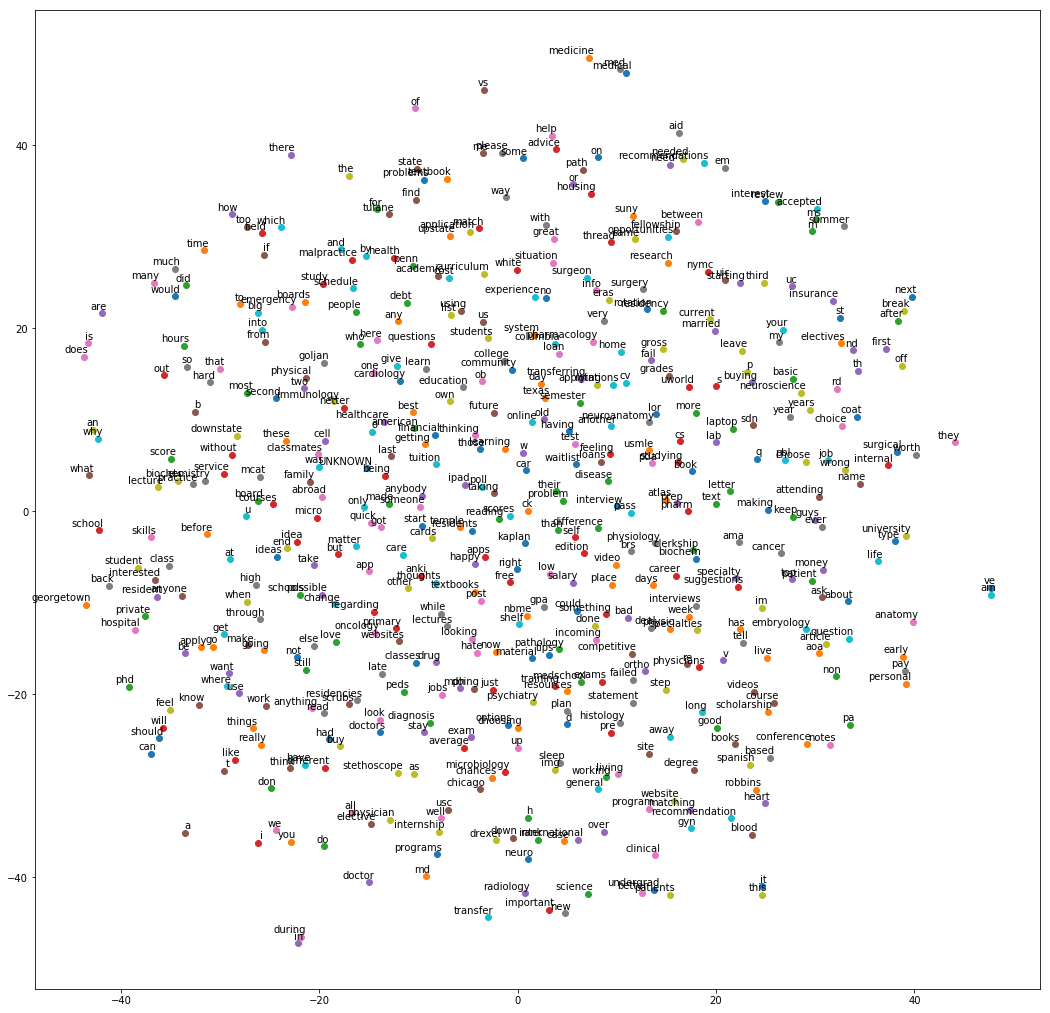

In [126]:
plot_with_labels(low_dim_embs, labels)